## TM-TV exercise

### 0. import resources

In [1]:
import nltk 
import spacy

import warnings

import matplotlib.pyplot as plt

import pyLDAvis
import pyLDAvis.gensim_models
from gensim.models import CoherenceModel, LdaModel
from gensim import corpora, similarities, utils
from gensim.models.phrases import Phrases, Phraser, ENGLISH_CONNECTOR_WORDS

from sklearn.datasets import fetch_20newsgroups

import matplotlib.colors as mcolors
from wordcloud import WordCloud

warnings.filterwarnings('ignore') # setting ignore as a parameter

nlp = spacy.load("en_core_web_sm")
stopwords = nltk.corpus.stopwords.words('english')

print("Libraries imported successfully!")

c:\Users\128525\AppData\Local\Programs\Python\Python39\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
c:\Users\128525\AppData\Local\Programs\Python\Python39\lib\site-packages\gensim\matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


Libraries imported successfully!


1. Create the corpus -> dictionary with frequency of words for each document and dictionary with tags associated (for further analysis)

1.1 Choose documents

1.2 Pre processing

1.3 Create the dictionary with frequencies 

In [17]:
newsgroups_train = fetch_20newsgroups(subset='train', shuffle = True, remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', shuffle = True, remove=('headers', 'footers', 'quotes'))

texts = newsgroups_train.data
targets = newsgroups_train.target
texts_test = newsgroups_test.data
targets_test = newsgroups_test.target
print(list(newsgroups_train.target_names))

print(newsgroups_train.data[:2])

print(len(texts))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
['I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.', "A fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Pleas

2. Create the model 

2.1 Pre processing

2.2 Building Dictionary & Corpus for Topic Model

2.3 Building LDA Topic Model

In [18]:
# Tokenization

def texts_to_tokens(texts: list): 
     texts_token = []
     texts = [text.replace("\n", " ") for text in texts]
     docs = list(nlp.pipe(texts, disable=['ner']))
     for doc in docs:
          text_tokens = [token.lemma_ for token in doc if len(token.text) > 2 and token.is_alpha and \
               token.pos_ in ['NOUN', 'PROPN', 'ADV'] and not token.is_punct and not token.is_stop]
          text_tokens = list(set(text_tokens))
          texts_token.append(text_tokens)

     return texts_token

def add_bigrams(texts_token: list):
     bigram = Phrases(texts_token, min_count=5, connector_words=ENGLISH_CONNECTOR_WORDS)
     for idx in range(len(texts_token)):
          for token in bigram[texts_token[idx]]:
               if '_' in token and token not in texts_token[idx]:
                    texts_token[idx].append(token)

     return texts_token

texts_token = texts_to_tokens(texts)
print("Tokenization done!")
print(texts_token[0])
texts_token = add_bigrams(texts_token)
print("added bigrams!")
print(texts_token[0])

Tokenization done!
['car', 'body', 'Bricklin', 'bumper', 'history', 'rest', 'spec', 'door', 'engine', 'production', 'year', 'info', 'mail', 'model', 'addition', 'day', 'sport']
added bigrams!
['car', 'body', 'Bricklin', 'bumper', 'history', 'rest', 'spec', 'door', 'engine', 'production', 'year', 'info', 'mail', 'model', 'addition', 'day', 'sport']


In [19]:

print(texts_token[:2])

[['car', 'body', 'Bricklin', 'bumper', 'history', 'rest', 'spec', 'door', 'engine', 'production', 'year', 'info', 'mail', 'model', 'addition', 'day', 'sport'], ['sink', 'oscillator', 'clock', 'speed', 'hour', 'adapter', 'poll', 'usage', 'heat', 'day', 'message', 'procedure', 'thank', 'functionality', 'disk', 'network', 'base', 'floppy', 'soul', 'CPU', 'experience', 'knowledge', 'number', 'especially', 'card', 'disk_network']]


In [20]:
dictionary = corpora.Dictionary(texts_token)
dictionary.filter_extremes(no_below=200, no_above=0.7)

In [21]:
corpus = [dictionary.doc2bow(text) for text in texts_token]

lda_model = LdaModel(corpus=corpus, num_topics=8, id2word=dictionary, random_state=100)
lda_model.show_topics()

[(0,
  '0.033*"people" + 0.020*"way" + 0.019*"time" + 0.019*"government" + 0.017*"law" + 0.017*"right" + 0.016*"thing" + 0.016*"year" + 0.015*"life" + 0.013*"problem"'),
 (1,
  '0.045*"game" + 0.036*"drive" + 0.035*"year" + 0.032*"time" + 0.027*"soon" + 0.025*"point" + 0.024*"thank" + 0.023*"team" + 0.021*"case" + 0.021*"disk"'),
 (2,
  '0.027*"people" + 0.019*"time" + 0.018*"God" + 0.018*"information" + 0.017*"group" + 0.015*"source" + 0.015*"number" + 0.015*"fact" + 0.015*"article" + 0.014*"hand"'),
 (3,
  '0.025*"thing" + 0.021*"year" + 0.021*"time" + 0.020*"people" + 0.019*"week" + 0.017*"cost" + 0.016*"month" + 0.015*"use" + 0.015*"rate" + 0.015*"lot"'),
 (4,
  '0.034*"team" + 0.030*"year" + 0.029*"time" + 0.028*"probably" + 0.028*"car" + 0.026*"thank" + 0.025*"day" + 0.023*"game" + 0.022*"home" + 0.018*"season"'),
 (5,
  '0.064*"problem" + 0.034*"window" + 0.027*"thank" + 0.025*"file" + 0.022*"question" + 0.020*"time" + 0.020*"program" + 0.018*"way" + 0.017*"idea" + 0.017*"screen

3. Visualizations of the model 

In [22]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.147051 -0.000060       1        1  25.922755
3     -0.060247 -0.000800       2        1  12.961443
2     -0.091284  0.095751       3        1  12.479270
7      0.177755  0.054560       4        1  11.686881
6     -0.001797  0.011172       5        1  10.906123
5      0.062739  0.085264       6        1  10.625887
4     -0.010247 -0.135615       7        1   8.746305
1      0.070132 -0.110273       8        1   6.671336, topic_info=         Term         Freq        Total Category  logprob  loglift
18      thank  1176.000000  1176.000000  Default  30.0000  30.0000
182      game   512.000000   512.000000  Default  29.0000  29.0000
67    problem  1355.000000  1355.000000  Default  28.0000  28.0000
8        year  1471.000000  1471.000000  Default  27.0000  27.0000
103      team   453.000000   453.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
51     system    98.958497   987.655637   Topic8  -4.1569   0.4067
55     course    79.736447   812.675433   Topic8  -4.3728   0.3857
37   question    78.665892  1006.862769   Topic8  -4.3864   0.1580
42        way    73.020988  1498.689825   Topic8  -4.4608  -0.3142
67    problem    58.269160  1355.908053   Topic8  -4.6865  -0.4398

[362 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
211       1  0.132122  April
211       2  0.204189  April
211       3  0.224207  April
211       5  0.004004  April
211       6  0.008007  April
...     ...       ...    ...
8         4  0.014268   year
8         5  0.197718   year
8         6  0.010871   year
8         7  0.167143   year
8         8  0.148798   year

[1642 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 8, 7, 6, 5, 2])

In [23]:
for i in range(len(texts)):
    print(lda_model[corpus][i])

[(0, 0.012511076), (1, 0.012506654), (2, 0.012509291), (3, 0.012508933), (4, 0.91244316), (5, 0.012504128), (6, 0.012508108), (7, 0.012508645)]
[(0, 0.010432538), (1, 0.010438421), (2, 0.010431927), (3, 0.010437806), (4, 0.0104384255), (5, 0.010433031), (6, 0.526076), (7, 0.4113118)]
[(1, 0.39693737), (4, 0.39572373), (7, 0.18574783)]
[(0, 0.020838266), (1, 0.020841), (2, 0.020854516), (3, 0.02084311), (4, 0.020839311), (5, 0.020840988), (6, 0.020856168), (7, 0.85408664)]
[(0, 0.015640551), (1, 0.01563865), (2, 0.01566709), (3, 0.015664184), (4, 0.015646704), (5, 0.5972933), (6, 0.015653988), (7, 0.30879545)]
[(0, 0.02087437), (1, 0.020865647), (2, 0.4590664), (3, 0.41581038), (4, 0.020843854), (5, 0.0208489), (6, 0.020845266), (7, 0.020845199)]
[(0, 0.012517571), (1, 0.0125115495), (2, 0.436084), (3, 0.012513283), (4, 0.01253011), (5, 0.012526611), (6, 0.012533317), (7, 0.4887836)]
[(5, 0.32170305), (7, 0.63132316)]
[(0, 0.06252503), (1, 0.062619075), (2, 0.06250809), (3, 0.0625224), 

4. Evaluation of the model

In [24]:

print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, corpus=corpus, texts=texts_token, dictionary=dictionary,
                                     coherence='u_mass', processes=3)
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.51706191891032

Coherence Score:  -2.221986211363986


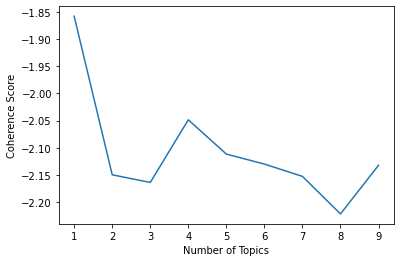

In [25]:
topics = []
score = []
for i in range(1,10,1):
   lda_model_eval = LdaModel(corpus=corpus, num_topics=i, id2word=dictionary, random_state=100)
   cm = CoherenceModel(model=lda_model_eval, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

5. Analysis of the topics using target

In [26]:
import pandas as pd

topics = [sorted(lda_model[corpus][text], key=lambda x: x[1], reverse=True)[0][0] for text in range(len(texts))]

topics_df = pd.DataFrame(topics, columns=['topic'])
topics_df['topic'].value_counts().sort_index()

0    3032
1     944
2    1150
3    1150
4    1195
5    1275
6     979
7    1589
Name: topic, dtype: int64

In [27]:
y_topic = topics_df['topic'].values
lda_topics = lda_model.show_topics(formatted=False)

lda_topics = [[word for word, prob in topic] for topicid, topic in lda_topics]

for text in range(len(texts)): 
    print("Text: ", text)
    print("Result model: ", lda_topics[y_topic[text]])
    print("Real tags: ", targets[text])

Text:  0
Result model:  ['team', 'year', 'time', 'probably', 'car', 'thank', 'day', 'game', 'home', 'season']
Real tags:  7
Text:  1
Result model:  ['system', 'year', 'time', 'question', 'thing', 'people', 'key', 'probably', 'datum', 'experience']
Real tags:  4
Text:  2
Result model:  ['game', 'drive', 'year', 'time', 'soon', 'point', 'thank', 'team', 'case', 'disk']
Real tags:  4
Text:  3
Result model:  ['thank', 'card', 'driver', 'line', 'chip', 'software', 'way', 'speed', 'price', 'video']
Real tags:  1
Text:  4
Result model:  ['problem', 'window', 'thank', 'file', 'question', 'time', 'program', 'way', 'idea', 'screen']
Real tags:  14
Text:  5
Result model:  ['thing', 'year', 'time', 'people', 'week', 'cost', 'month', 'use', 'rate', 'lot']
Real tags:  16
Text:  6
Result model:  ['thank', 'card', 'driver', 'line', 'chip', 'software', 'way', 'speed', 'price', 'video']
Real tags:  13
Text:  7
Result model:  ['thank', 'card', 'driver', 'line', 'chip', 'software', 'way', 'speed', 'price'

Unseen documents

In [28]:
# Data preprocessing step for the unseen document
bow_vector = dictionary.doc2bow((texts_test))

for index, score in sorted(lda_model[bow_vector], key=lambda tup: tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))


Score: 0.125	 Topic: 0.033*"people" + 0.020*"way" + 0.019*"time" + 0.019*"government" + 0.017*"law"
Score: 0.125	 Topic: 0.045*"game" + 0.036*"drive" + 0.035*"year" + 0.032*"time" + 0.027*"soon"
Score: 0.125	 Topic: 0.027*"people" + 0.019*"time" + 0.018*"God" + 0.018*"information" + 0.017*"group"
Score: 0.125	 Topic: 0.025*"thing" + 0.021*"year" + 0.021*"time" + 0.020*"people" + 0.019*"week"
Score: 0.125	 Topic: 0.034*"team" + 0.030*"year" + 0.029*"time" + 0.028*"probably" + 0.028*"car"
Score: 0.125	 Topic: 0.064*"problem" + 0.034*"window" + 0.027*"thank" + 0.025*"file" + 0.022*"question"
Score: 0.125	 Topic: 0.032*"system" + 0.028*"year" + 0.027*"time" + 0.021*"question" + 0.021*"thing"
Score: 0.125	 Topic: 0.041*"thank" + 0.031*"card" + 0.023*"driver" + 0.019*"line" + 0.018*"chip"


### Wordcloud

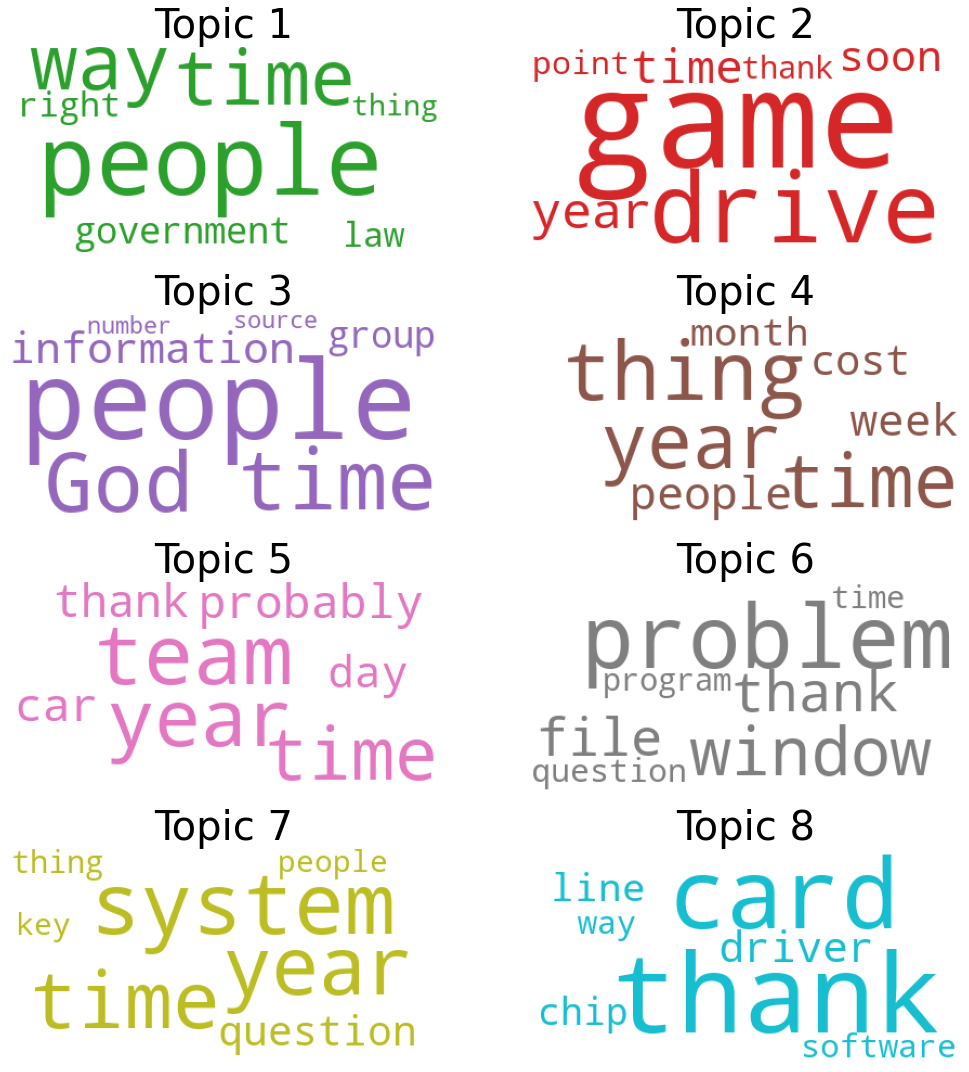

In [29]:
cols = list(mcolors.TABLEAU_COLORS.values())

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  color_func=lambda *_, **kwargs: cols[-8+i],
                  max_words=7,
                  prefer_horizontal=True)

topics = lda_model.show_topics(formatted=False, num_topics=8, num_words=10)
fig, axes = plt.subplots(4, 2, figsize=(15,15))

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words)
    plt.gca().axis('off')
    plt.gca().imshow(cloud)
    plt.gca().set_title(f'Topic {i+1}', font=dict(size=40))

plt.tight_layout()
plt.show()